In [56]:
# -*- coding: utf-8 -*-
#  Copyright 2024 -  United Kingdom Research and Innovation
#  Copyright 2024 -  The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Hannah Robarts (STFC - UKRI)
#                   Laura Murgatroyd (STFC - UKRI)

# Paganin Processor 
This demo contains some examples and comparisons of using the `PaganinProcessor` phase retrieval methods in CIL.

#### Phase contrast imaging
Phase contrast imaging is commonly used in tomography as a tool to exploit the different contrast provided by absorption and phase.

In absorption contrast imaging, variation in beam intensity $I$ is given by,
$$
I  = I_0\exp(-\mu T),
$$
where $T$ is the material thickness and $\mu$ is the material linear attenuation coefficient, which we can also express in terms of the **complex** part of the material refractive index $\mu = 2k\beta$

Variation in material phase $\phi$ is given by,
$$
\phi = -k\delta T,
$$
where $k$ is the wavevector of the x-rays (or other probe) and $\delta$ is the **real** part of the material refractive index.

Phase contrast imaging is commonly used in samples which give poor absorption contrast, like light element materials, to resolve details which might not otherwise be resolved with absorption contrast alone.

#### Propagation-based phase contrast
The simplest methods to enable phase contrast imaging are propagation-based methods. These rely on the fact that a phase shift caused by the sample, results in the x-rays (or other probe) propagating differently, or refracting, which is measured as a variation in intensity at the detector after some propagation distance $\Delta$. This causes bright fringes around edges in the sample, known as edge enhancement. These can be really helpful for highlighting features in the sample for example for segmentation.

#### Phase retrieval
However, edge-enhancement changes the intensity profile in the projections by combining the absorption and phase information. So in certain circumstances - for example where quantitative measurement of sample features is required - phase retrieval methods are used to separate these effects. This notebook uses the commonly used Paganin phase retrieval method which solves the transport of intensity equation to retrieve the quantitative sample thickness from phase contrast images [Paganin 2002](https://onlinelibrary.wiley.com/doi/10.1046/j.1365-2818.2002.01010.x). The form of the phase retrieval additionally acts as a filter on the data, which if used with the correct physical parameters, results in a boost to the signal to noise ratio (SNR) without losing resolution. Paganin phase retrieval is therefore also commonly used as a filter to boost SNR in many different contexts.

This notebook requires CIL v24.1.0 or greater, check the version below

In [57]:
import cil
print(cil.__version__)

24.2.0


Load some dependencies

In [58]:
from cil.utilities import dataexample
from cil.processors import PaganinProcessor, TransmissionAbsorptionConverter, Padder, Normaliser
from cil.utilities.display import show2D
from cil.recon import FDK, FBP
from cil.io.utilities import HDF5_utilities
from cil.framework import AcquisitionGeometry, AcquisitionData
import numpy as np
import matplotlib.pyplot as plt 
from scipy import constants

##### Simulated parallel beam data

First we test the PaganinProcessor with a simulated data example from CIL just to show how the processor works. 
`dataexample.SIMULATED_PARALLEL_BEAM_DATA` is a simualted dataset with parallel beam geometry

In [59]:
data = dataexample.SIMULATED_PARALLEL_BEAM_DATA.get()

We convert from transmission to absorption, get a single slice, and reconstruct the data using CIL filtered back projection `FBP()`

In [60]:
data_abs = -1*data.log()
# get a slice
vertical_slice = 64
data_slice = data_abs.get_slice(vertical=vertical_slice)
ig = data_slice.geometry.get_ImageGeometry()
# reconstruct the slice
fbp =  FBP(data_slice, ig)
recon = fbp.run(verbose=0)

Next we run the phase retrieval on the same data with the `PaganinProcessor` which is implemented based on [Paganin 2002](https://onlinelibrary.wiley.com/doi/10.1046/j.1365-2818.2002.01010.x). The processor returns the material retrieved thickness, removing the effect of phase in the image

$$
T(x,y) = - \frac{1}{\mu}\ln\left (\mathcal{F}^{-1}\left 
        (\frac{\mathcal{F}\left ( M^2I_{norm}(x, y,z = \Delta) \right )}{1 + 
          \alpha\left ( k_x^2 + k_y^2 \right )}  \right )\right )
$$

where
- $T$, is the sample thickness,
- $\mu = \frac{4\pi\beta}{\lambda}$ is the material linear 
attenuation coefficient where $\beta$ is the complex part of the 
material refractive index and $\lambda=\frac{hc}{E}$ is the probe 
wavelength,
- $M$ is the magnification at the detector,
- $I_{norm}$ is the input image which is expected to be the 
normalised transmission data, 
- $\Delta$ is the propagation distance,
- $\alpha = \frac{\Delta\delta}{\mu}$ is a parameter determining 
the strength of the filter to be applied in Fourier space where 
$\delta$ is the real part of the deviation of the material 
refractive index from 1 
- $k_x, k_y = \left ( \frac{2\pi p}{N_xW}, \frac{2\pi q}{N_yW} 
\right )$ where $p$ and $q$ are co-ordinates in a Fourier 
mesh in the range $-N_x/2$ to $N_x/2$ for an image with 
size $N_x, N_y$ and pixel size $W$.


First check if the propagation distance, pixel sizes and units are already stored in the data geometry.

In [61]:
print(data.geometry.dist_center_detector)
print(data.geometry.pixel_size_h)
print(data.geometry.config.units)

0.0
16.0
units distance


There is no propagation distance stored which is common for parallel beam data as it isn't needed for a simple reconstruction. We can either create the geometry again with the propagation distance defined or use the override geometry argument. The units for override geometry are defined in `PaganinProcessor`, by default this is cm. In the data there are pixels but no units, so we need to specify the units are $\mu$ m

In [62]:
override_geometry={'propagation_distance':10}
data.geometry.config.units = 'um'


Specify the experiment peak energy and units

In [63]:
energy = 40000
energy_units = 'eV'

Choose $\delta$ and $\beta$, the real and complex part of the material refractive index. These can be found for real materials at x-ray wavelengths at https://henke.lbl.gov/optical_constants/getdb2.html. 
A larger difference between $\delta$ and $\beta$ results in a stronger phase retrieval, or stronger filtering effect, here we use a large difference to demonstrate the effect. 

In [64]:
delta = 1
beta = 0.002

Set up the `PaganinProcessor` with all the above parameters

In [65]:
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy)
processor.set_input(data)
thickness = processor.get_output(override_geometry=override_geometry)

100%|██████████| 300/300 [00:00<00:00, 1988.95it/s]


Reconstruct a slice of the data

In [66]:
# get a slice
data_slice = thickness.get_slice(vertical=vertical_slice)
# reconstruct the slice
fbp =  FBP(data_slice, ig)
recon_thickness = fbp.run(verbose=0)

So far we have the retrieved thickness, but to get the reconstruction on the same scale as the original data we have to multiply by the linear attenuation coefficient. We can get this from the `PaganinProcessor` by calling `processor.mu`. Multiply $\mu$ by $T$ and reconstruct.

In [67]:
attenuation = thickness*processor.mu
# get a slice
data_slice = attenuation.get_slice(vertical=vertical_slice)
# reconstruct the slice
fbp =  FBP(data_slice, ig)
recon_attenuation = fbp.run(verbose=0)

Next we test the phase retrieval using `PaganinProcessor(full_retrieval=False)`. In this implementation, the same filter is applied in Fourier space but the $-log()$ is not applied. 
$$
I_{filt} = \mathcal{F}^{-1}\left (\frac{\mathcal{F}\left ( 
        I(x, y,z = \Delta) \right )}
        {1 - \alpha\left ( k_x^2 + k_y^2 \right )}  \right )
$$
This gives flexibility to apply a Paganin-like filter but doesn't require data that has already been converted from transmission to absorption.


In [68]:
data_abs.geometry.config.units = 'um'
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy, full_retrieval=False)
processor.set_input(data_abs)
filtered_image = processor.get_output(override_geometry=override_geometry)

100%|██████████| 300/300 [00:00<00:00, 2458.06it/s]


Reconstruct a slice of the filtered data

In [69]:
# get a slice
data_slice = filtered_image.get_slice(vertical=vertical_slice)
# reconstruct the slice
fbp =  FBP(data_slice, ig)
recon_filter = fbp.run(verbose=0)

Compare the reconstructions using `show2D()`

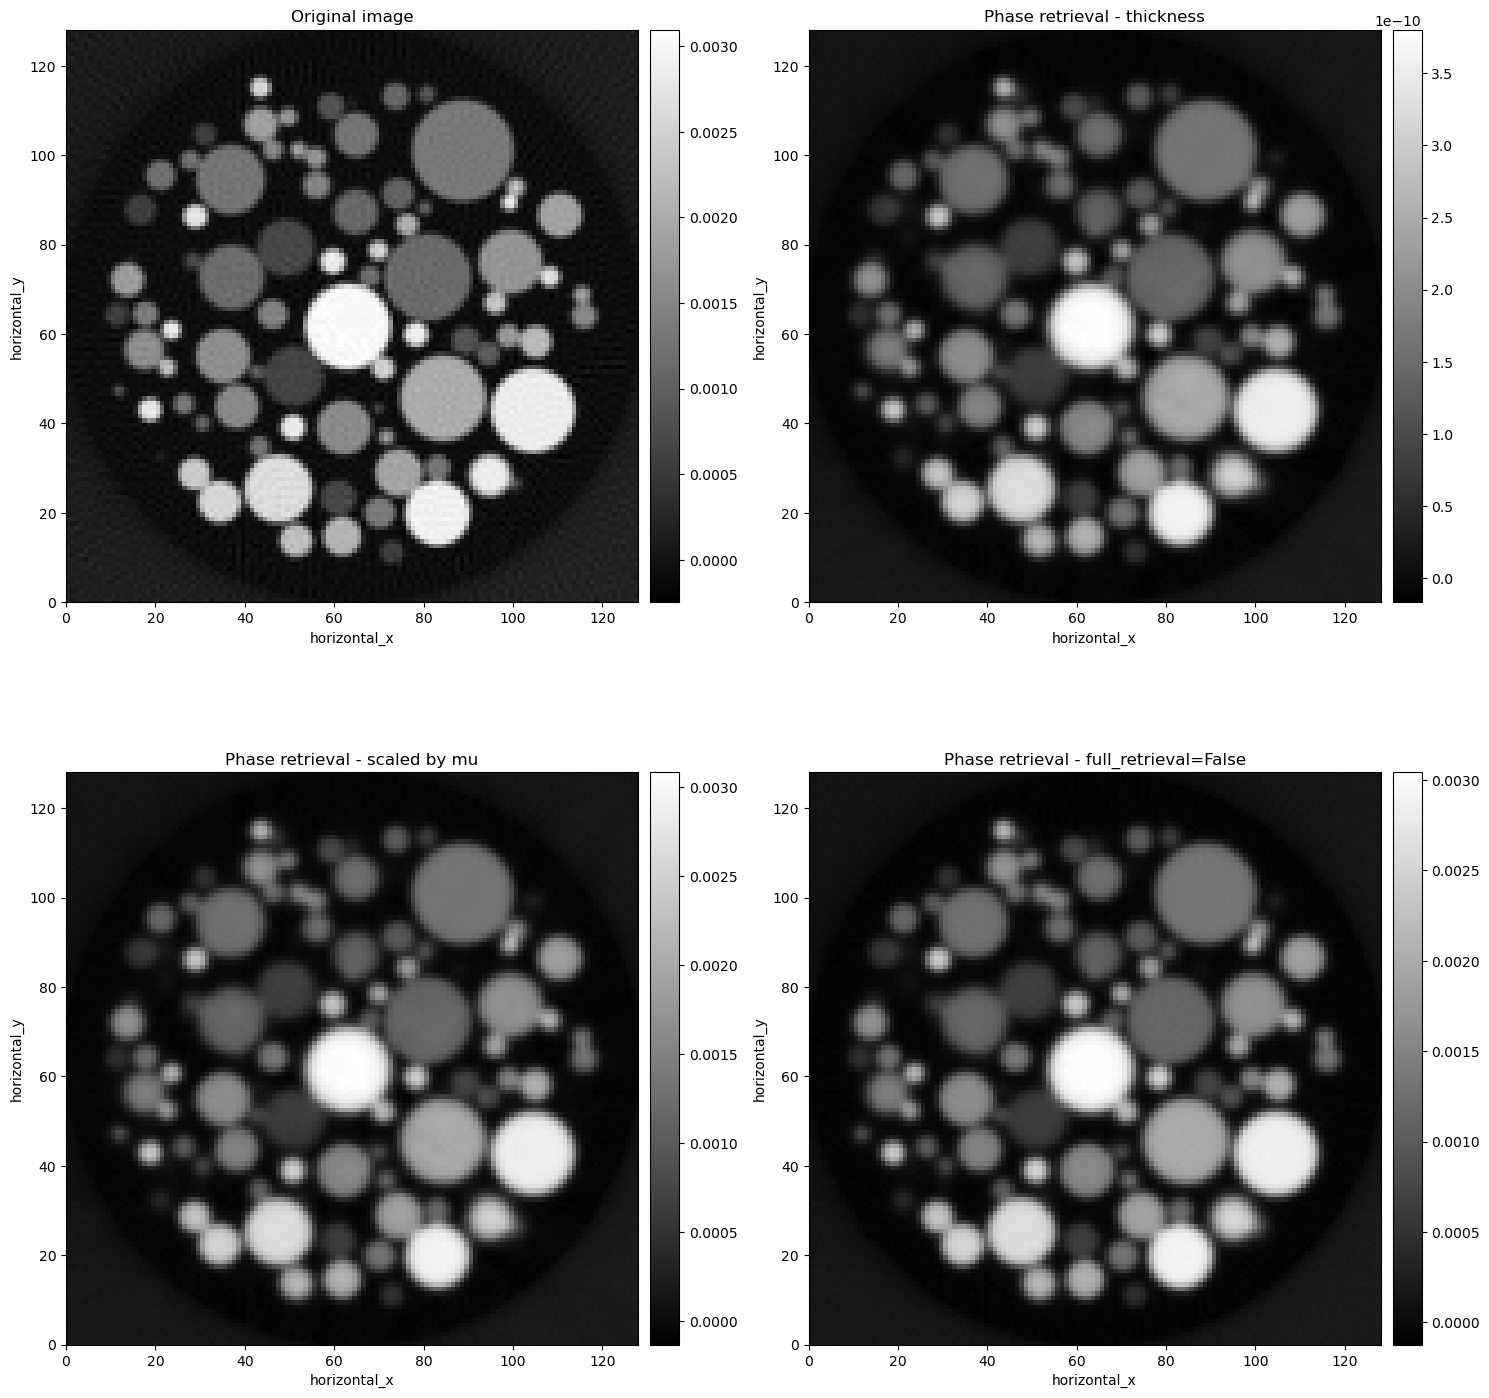

In [70]:
show2D([recon, recon_thickness, recon_attenuation, recon_filter],
        title=['Original image', 'Phase retrieval - thickness', 'Phase retrieval - scaled by mu', 
               'Phase retrieval - full_retrieval=False'])

Zoom in on the reconstructions

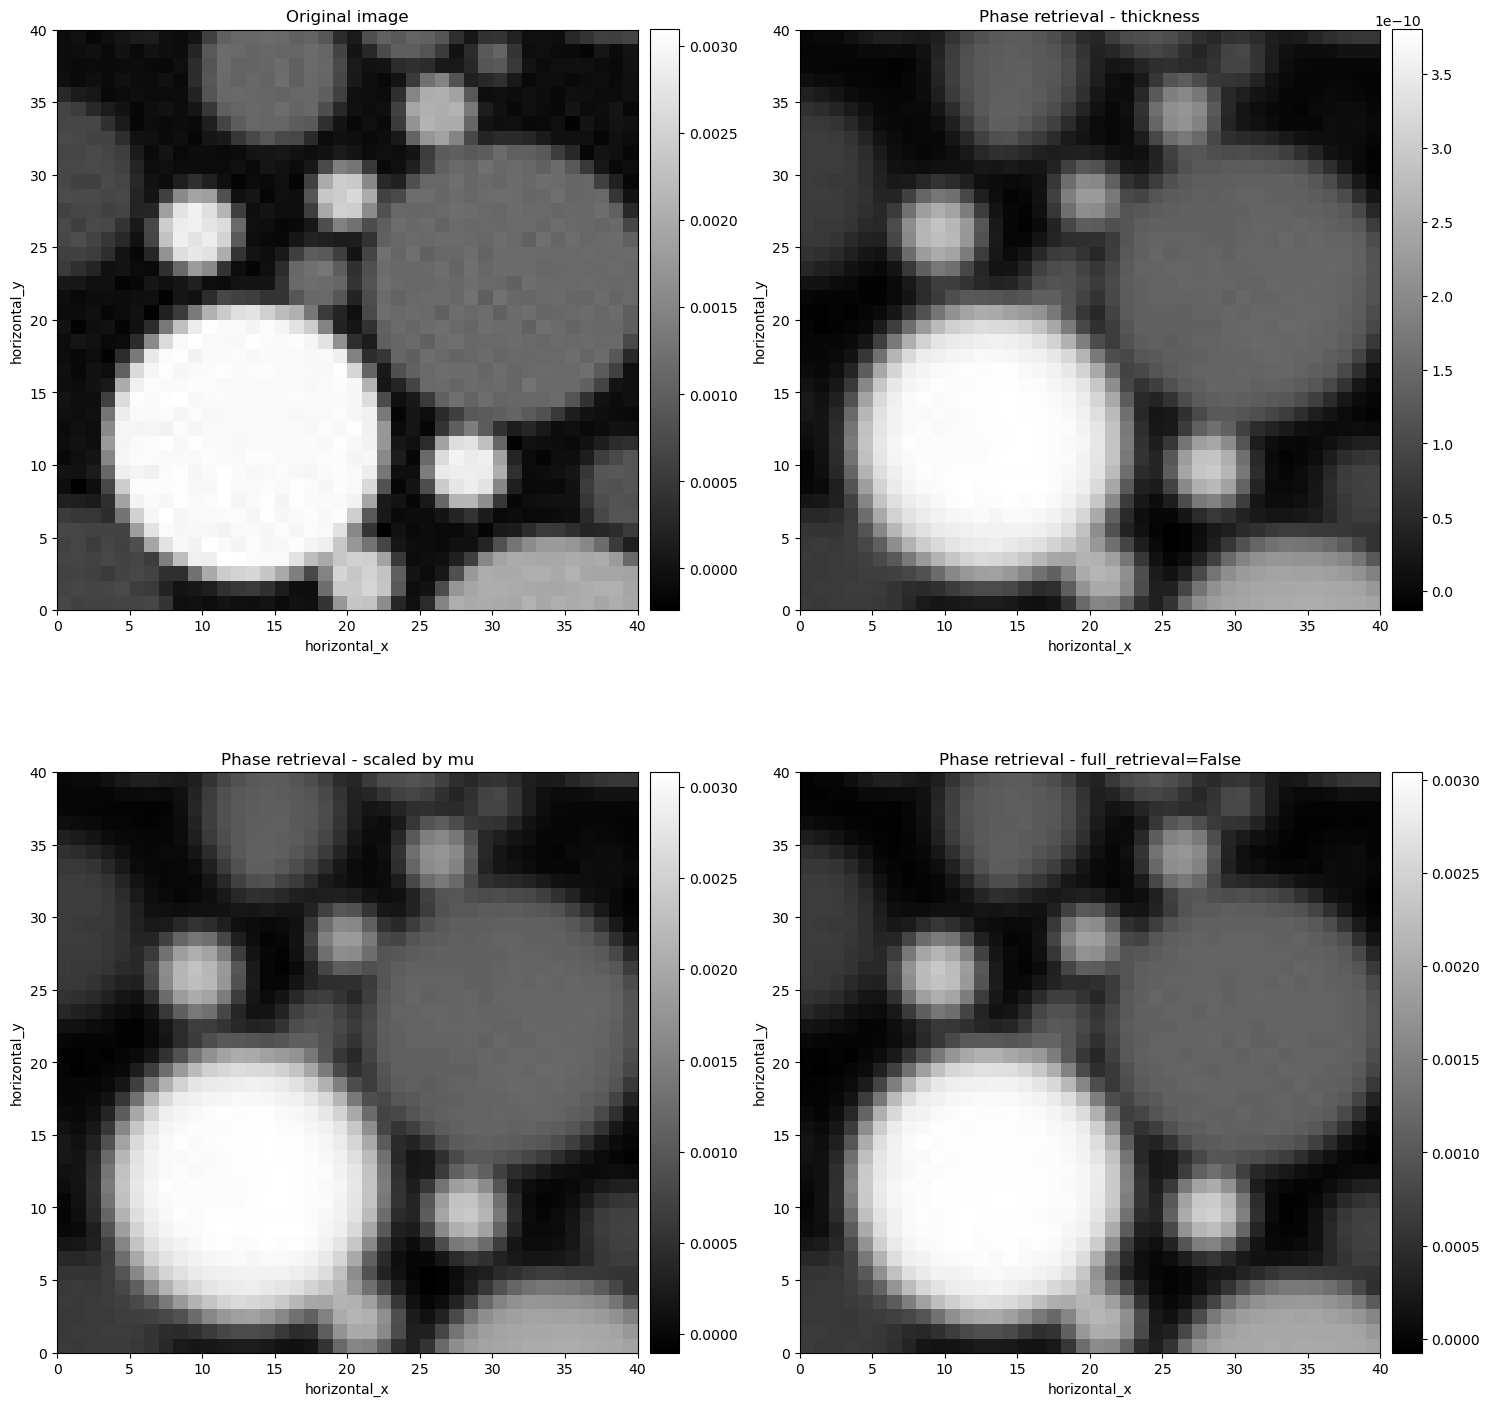

In [71]:
x_range = slice(50,90)
y_range = slice(50,90)

show2D([recon.array[x_range,y_range], recon_thickness.array[x_range,y_range], recon_attenuation.array[x_range,y_range], recon_filter.array[x_range,y_range]],
title=['Original image', 'Phase retrieval - thickness', 'Phase retrieval - scaled by mu', 'Phase retrieval - full_retrieval=False'], 
axis_labels = ('horizontal_x', 'horizontal_y'))

Compare a cross-section through the reconstruction

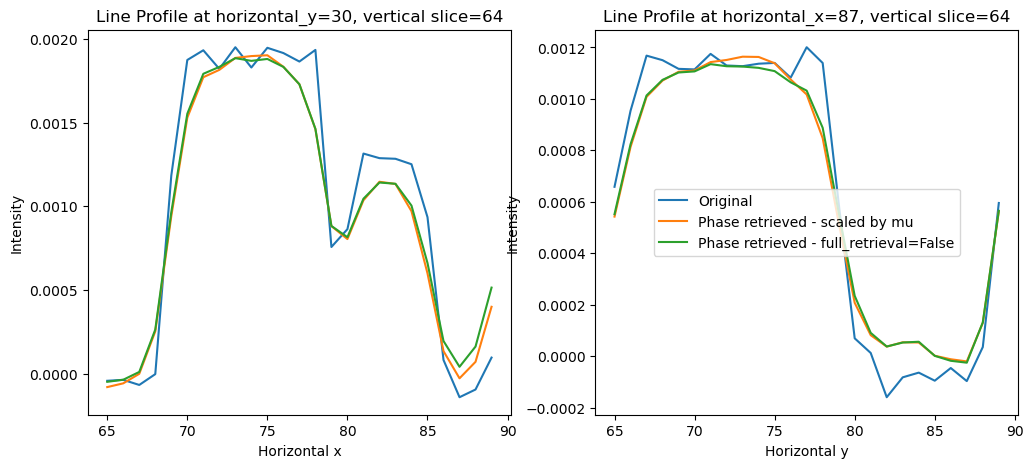

In [72]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
ax = axs[0]

y_slice = 30
x_range = range(65,90)
ax.plot(x_range, recon.array[y_slice,x_range])
ax.plot(x_range, recon_attenuation.array[y_slice,x_range])
ax.plot(x_range, recon_filter.array[y_slice,x_range])

ax.set_xlabel('Horizontal x')
ax.set_ylabel('Intensity')
ax.set_title('Line Profile at horizontal_y=' + str(y_slice) + ', vertical slice=' + str(vertical_slice))

ax = axs[1]
x_slice = 87
y_range = range(65,90)
ax.plot(y_range, recon.array[y_range,x_slice])
ax.plot(y_range, recon_attenuation.array[y_range,x_slice])
ax.plot(y_range, recon_filter.array[y_range,x_slice])

ax.set_xlabel('Horizontal y')
ax.set_ylabel('Intensity')
ax.set_title('Line Profile at horizontal_x=' + str(x_slice) + ', vertical slice=' + str(vertical_slice))
ax.legend(['Original', 'Phase retrieved - scaled by mu', 'Phase retrieved - full_retrieval=False'])

We see that both methods blur the result in comparison to the original reconstruction.


We can approximate the signal to noise of each reconstruction as the mean divided by the standard deviation

In [73]:
print("Original reconstruction SNR = {:.3f}".format(np.abs(recon.mean()/recon.array.std())))
print("Phase retrieved reconstruction SNR = {:.3f}".format(np.abs(recon_attenuation.mean()/recon_attenuation.array.std())))
print("Phase retrieved (full_retrieval=False) reconstruction SNR = {:.3f}".format(np.abs(recon_filter.mean()/recon_filter.array.std())))

Original reconstruction SNR = 0.604
Phase retrieved reconstruction SNR = 0.665
Phase retrieved (full_retrieval=False) reconstruction SNR = 0.670


In all cases, the phase retrieval improves the SNR. The filter performs very similarly to the full phase retrieval in this case but should not be used where the aim is to obtain quantitative information from the resonstruction.

##### Generalised Paganin method

The generalised Paganin method is implemented in CIL following the description in [Paganin 2020](https://iopscience.iop.org/article/10.1088/2040-8986/abbab9) \
When features in the image are close to the Nyquist frequency of the system, a more generalised form of the Pagnin filter can be used which preserves these high frequency features while still boosting SNR. This may have a similar effect to applying an unsharp mask after the normal Paganin phase retrieval. 

$$
T(x,y) =  -\frac{1}{\mu}\ln\left (\mathcal{F}^{-1}\left (\frac{
        \mathcal{F}\left (I_{norm}(x, y,z = \Delta) \right )}{1 - \frac{2
        \alpha}{W^2}\left ( \cos(Wk_x) + \cos(Wk_y) -2 \right )}  \right )
        \right )
$$

Run phase retrieval on the data using the generalised Paganin method to get thickness and attenuation

In [74]:
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy, filter_type='generalised_paganin_method')
processor.set_input(data)
thickness_GPM = processor.get_output(override_geometry={'propagation_distance':10})
attenuation_GPM = thickness_GPM*processor.mu # multiply by mu to get recon_attenuation with the same scaling as the original image

100%|██████████| 300/300 [00:00<00:00, 2001.82it/s]


Reconstruct slices of the data

In [75]:
# get a slice
data_slice = thickness_GPM.get_slice(vertical=vertical_slice)
# reconstruct the slice
fbp =  FBP(data_slice, ig)
recon_thickness_GPM = fbp.run(verbose=0)

# get a slice
data_slice = attenuation_GPM.get_slice(vertical=vertical_slice)
# reconstruct the slice
fbp =  FBP(data_slice, ig)
recon_attenuation_GPM = fbp.run(verbose=0)

Zoom in on a region with high frequency features, i.e. where some of the sphere are almost touching

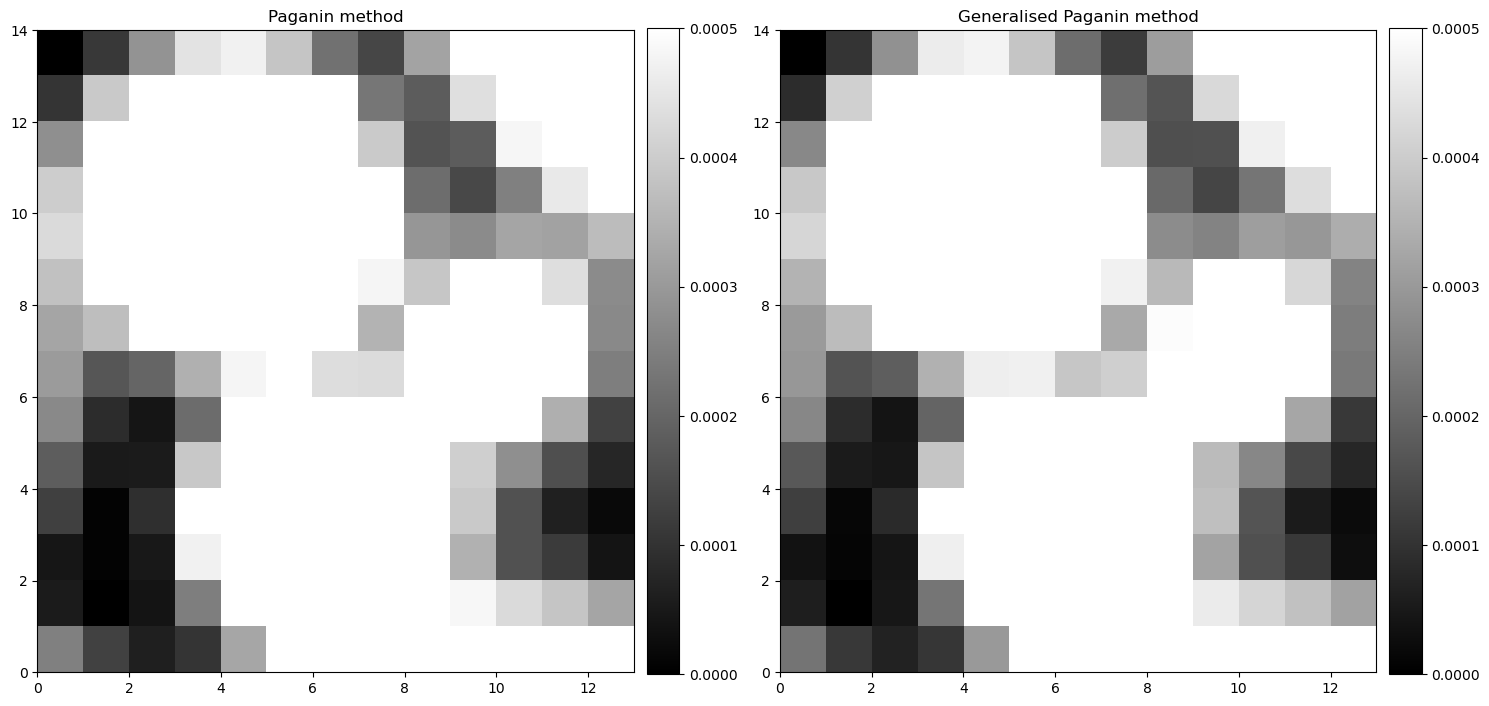

In [80]:
show2D([recon_attenuation.array[81:95,70:83],recon_attenuation_GPM.array[81:95,70:83]],
       title=['Paganin method', 'Generalised Paganin method'], fix_range=(0.000, 0.0005))

Plot a difference map between the PM and GPM

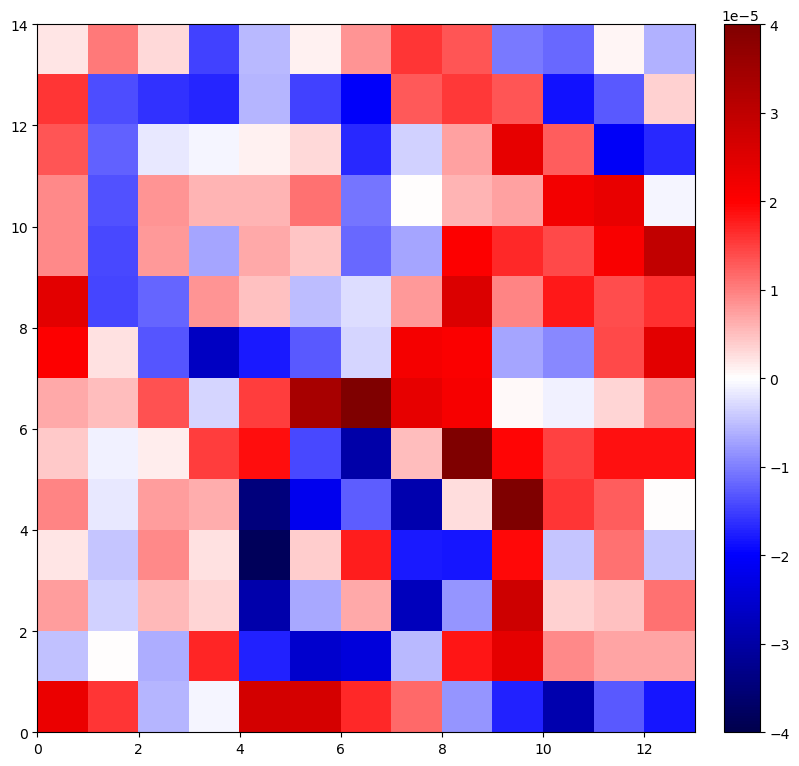

In [81]:
show2D([recon_attenuation.array[81:95,70:83]-recon_attenuation_GPM.array[81:95,70:83]], cmap='seismic', fix_range=(-4e-5, 4e-5))

Some high frequency features are better maintained by the GPM compared to the PM, which might allow easier segmentation. In this example the difference is very small. 

Check the SNR

In [29]:
print("Original reconstruction SNR = {:.3f}".format(np.abs(recon.mean()/recon.array.std())))
print("Phase retrieved reconstruction SNR = {:.3f}".format(np.abs(recon_attenuation.mean()/recon_attenuation.array.std())))
print("Phase retrieved with GPM reconstruction SNR  =  {:.3f}".format(np.abs(recon_attenuation_GPM.mean()/recon_attenuation_GPM.array.std())))

Original reconstruction SNR = 0.604
Phase retrieved reconstruction SNR = 0.665
Phase retrieved with GPM reconstruction SNR  =  0.663


The GPM has slightly improved resolution of the sample features while maintaining the SNR boost

#### TomoBank example

This example demonstrated phase retrieval on a realm dataset: tomo_00064 and tomo_00065 from TomoBank multi-distance dataset [1] https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#multi-distance

The relevant datasets can be retrieved using:

`wget https://g-a0400.fd635.8443.data.globus.org/tomo_00064_to_00067/tomo_00064.h5`

and `wget https://g-a0400.fd635.8443.data.globus.org/tomo_00064_to_00067/tomo_00065.h5`

[1] De Carlo, Francesco, et al. “TomoBank: a tomographic data repository for computational x-ray science.” Measurement Science and Technology 29.3 (2018): 034004. http://www.doi.org/10.1088/1361-6501/aa9c19

Load the file, you may need to change the filename to the path where you downloaded it

In [106]:
filename = '/mnt/share/materials/SIRF/Fully3D/CIL/Phase/tomo_00065.h5' 
data = HDF5_utilities.read(filename=filename, dset_path='/exchange/data')
data_dark = HDF5_utilities.read(filename, dset_path='/exchange/data_dark')
data_flat = HDF5_utilities.read(filename, dset_path='/exchange/data_white')

Construct a CIL AcquisitionData object using the parameters in https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#multi-distance

In [107]:
pixel_size = 0.0014 #mm
propagation_distance = 58 #mm
angles = HDF5_utilities.read(filename=filename, dset_path='/exchange/theta')
ag = AcquisitionGeometry.create_Parallel3D(detector_position=[0, propagation_distance, 0], units='mm').set_panel([np.shape(data)[2],np.shape(data)[1]], pixel_size=pixel_size).set_angles(angles)
data = AcquisitionData(data, deep_copy=False, geometry = ag)
data.reorder(order='tigre')

Normalise the data

In [108]:
data = Normaliser(dark_field=data_dark.mean(axis=0), flat_field=data_flat.mean(axis=0))(data)

Get a slice of the data

In [110]:
vertical_slice = 325
data_slice = data.get_slice(vertical=vertical_slice)

Convert to absorption

In [111]:
processor = TransmissionAbsorptionConverter()
processor.set_input(data_slice)
processor.get_output(out=data_slice)

Pad the data to remove the effects of parts of the sample moving out of the field of view during the scan

In [112]:
# Pad the data
ig = data_slice.geometry.get_ImageGeometry()
padsize = 500
data_slice = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_slice)

Reconstruct the dataset and use `show2D()` to view it

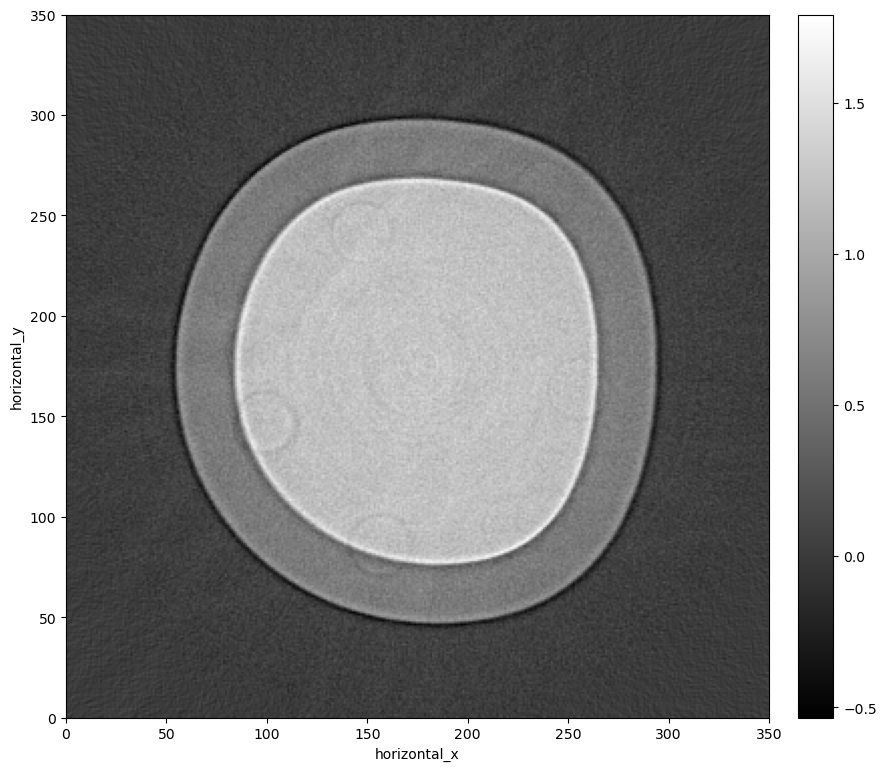

In [113]:
fbp =  FBP(data_slice, ig)
recon = fbp.run(verbose=0)
show2D(recon)

There are significant edge enhancements in this dataset. Take a closer look by plotting a cross-section through the reconstruction

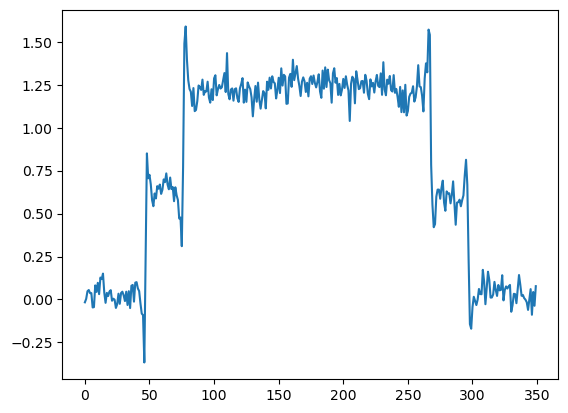

In [114]:
plt.plot(recon.array[:,175])

We can see bright fringes at the edge of the sample which are due to phase contrast

Next we try a phase retrieval on the raw data to remove the fringes

Get the experiment parameters from https://tomobank.readthedocs.io/en/latest/source/data/docs.data.phasecontrast.html#multi-distance ,
$\delta$ and $\beta$ are an approximation based on the density of steel

In [115]:
delta = 1e-6
beta = 1e-9
energy = 55000

processor = PaganinProcessor(delta=delta, beta=beta, energy=energy)
processor.set_input(data)
thickness = processor.get_output()


data_phase = thickness*processor.mu # use mu to get recon_attenuation with the same scaling as the original image

100%|██████████| 450/450 [00:03<00:00, 143.24it/s]


Run phase retrieval using the generalised Paganin method on the raw data

In [117]:
processor = PaganinProcessor(delta=delta, beta=beta, energy=energy, 
                             filter_type='generalised_paganin_method')
processor.set_input(data)
thickness = processor.get_output()

data_phase_generalised = thickness*processor.mu # use mu to get recon_attenuation with the same scaling as the original image

100%|██████████| 450/450 [00:03<00:00, 143.66it/s]


Get a slice of each data set

In [118]:
data_phase = data_phase.get_slice(vertical=vertical_slice)
data_phase_generalised = data_phase_generalised.get_slice(vertical=vertical_slice)

Pad the data

In [119]:
# Pad the data
data_phase = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_phase)
data_phase_generalised = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_phase_generalised)

Reconstruct

In [120]:
# Reconstruct
fbp =  FBP(data_phase, ig)
recon_phase = fbp.run(verbose=0)

fbp =  FBP(data_phase_generalised, ig)
recon_phase_g = fbp.run(verbose=0)

Compare the reconstructions

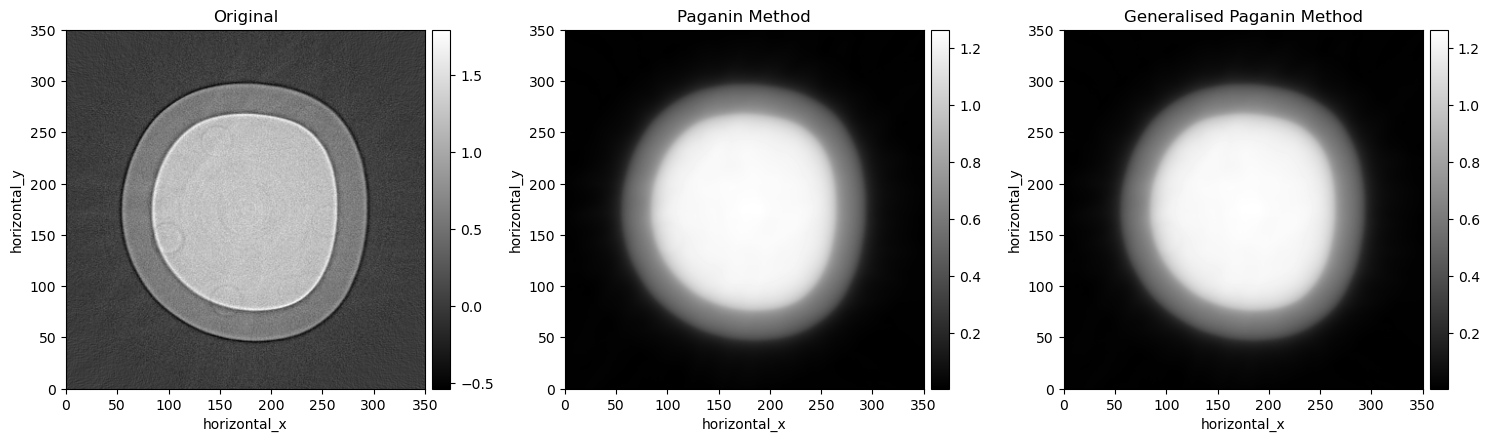

In [121]:
show2D([recon, recon_phase, recon_phase_g], ['Original','Paganin Method', 'Generalised Paganin Method'], num_cols=3, slice_list={'horizontal_y':175})

Plot a difference map between the Paganin Method and Generalised Paganin Method reconstructions

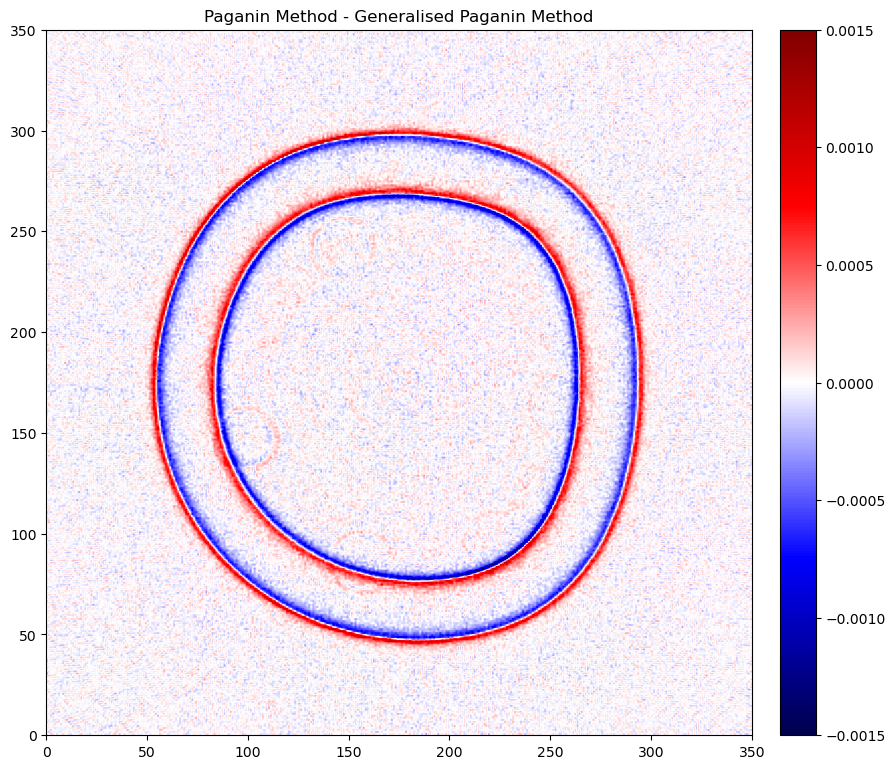

In [122]:
show2D(recon_phase.array-recon_phase_g.array, title='Paganin Method - Generalised Paganin Method', cmap='seismic', fix_range=(-0.0015, 0.0015), slice_list={'horizontal_y':175})

We see some of the high resolution details (e.g. the edges) are preserved in the GPM

Compare SNR

In [94]:
print("Original reconstruction SNR = {:.3f}".format(np.abs(recon.mean()/recon.array.std())))
print("Phase retrieved reconstruction SNR = {:.3f}".format(np.abs(recon_phase.mean()/recon_phase.array.std())))
print("Phase retrieved with GPM reconstruction SNR = {:.3f}".format(np.abs(recon_phase_g.mean()/recon_phase_g.array.std())))

Original reconstruction SNR = 0.773
Phase retrieved reconstruction SNR = 0.820
Phase retrieved with GPM reconstruction SNR = 0.820


Plot cross-sections through the reconstructions to check how well the phase retrieval removes the fringes

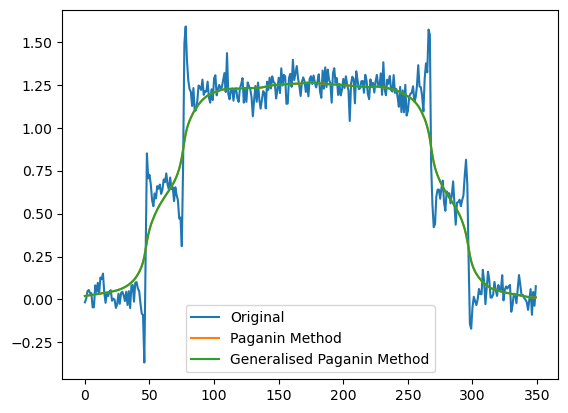

In [95]:
plt.plot(recon.array[:,175])
plt.plot(recon_phase.array[:,175])
plt.plot(recon_phase_g.array[:,175])
plt.legend(['Original', 'Paganin Method', 'Generalised Paganin Method'])

We can also compare the phase retrieval with the same sample which was imaged with a much shorted propagation distance (8mm)

In [97]:
filename = '/mnt/share/materials/SIRF/Fully3D/CIL/Phase/tomo_00064.h5' 
data_8mm = HDF5_utilities.read(filename=filename, dset_path='/exchange/data')
data_dark = HDF5_utilities.read(filename, dset_path='/exchange/data_dark')
data_flat = HDF5_utilities.read(filename, dset_path='/exchange/data_white')

In [98]:
pixel_size = 0.0014 #mm
propagation_distance = 8 #mm
angles = HDF5_utilities.read(filename=filename, dset_path='/exchange/theta')
ag = AcquisitionGeometry.create_Parallel3D(detector_position=[0, propagation_distance, 0], units='mm').set_panel([np.shape(data)[2],np.shape(data)[1]], pixel_size=pixel_size).set_angles(angles)
data_8mm = AcquisitionData(data_8mm, deep_copy=False, geometry = ag)
data_8mm.reorder(order='tigre')

In [99]:
data_8mm = Normaliser(dark_field=data_dark.mean(axis=0), flat_field=data_flat.mean(axis=0))(data_8mm)

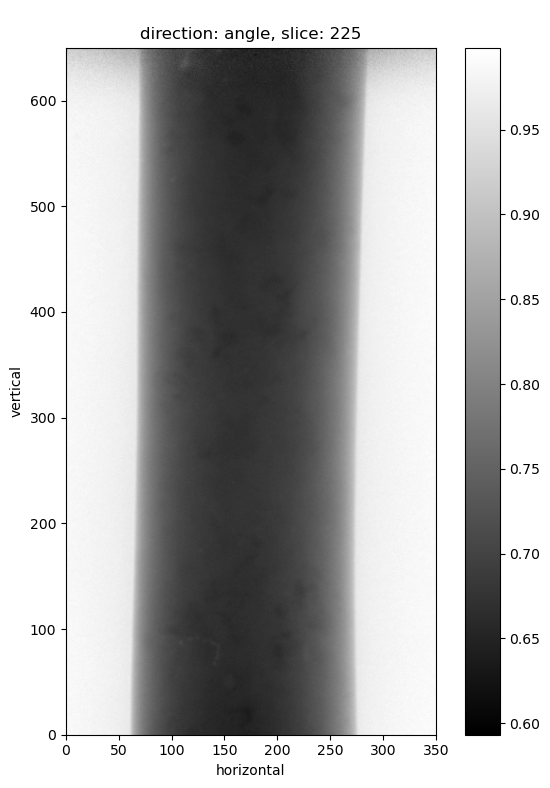

In [100]:
show2D(data_8mm)

Get a single slice and convert to absorption

In [101]:
data_slice_8mm = data_8mm.get_slice(vertical=vertical_slice)

processor = TransmissionAbsorptionConverter(min_intensity=0.001)
processor.set_input(data_slice_8mm)
processor.get_output(out=data_slice_8mm)


Pad the data and reconstruct it

In [102]:
# Pad the data
ig = data_slice_8mm.geometry.get_ImageGeometry()
padsize = 500
data_slice_8mm = Padder.linear_ramp(pad_width={'horizontal': padsize}, end_values=0)(data_slice_8mm)
# Reconstruct
fbp =  FBP(data_slice_8mm, ig)
recon_8mm = fbp.run(verbose=0)

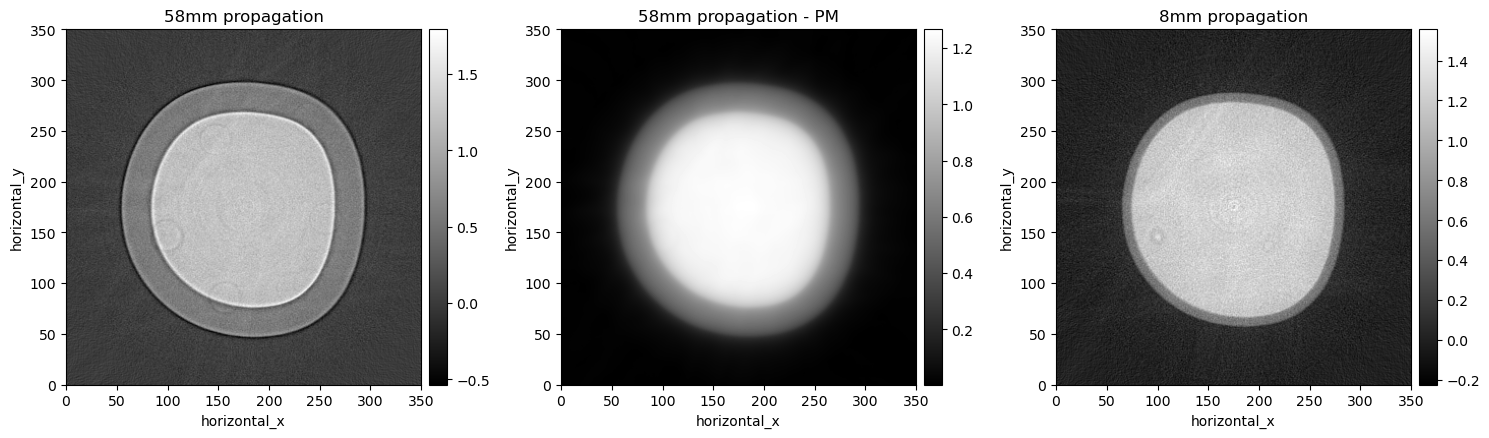

In [103]:
show2D([recon, recon_phase, recon_8mm], ['58mm propagation', '58mm propagation - PM', '8mm propagation'], num_cols=3, slice_list={'horizontal_y':175})

The phase retrieval acts as an effective filter but it doesn't return the original shape of the sample which was measured with 8mm propagation distance.

We can check if we are in the Fresnel limit by calculating the Fresnel Number
$$
N_F = \frac{W^2}{\lambda\Delta} >> 1
$$

In [104]:
wavelength = (constants.h*constants.speed_of_light)/(energy*constants.electron_volt)
NF = (data.geometry.pixel_size_h*1e-3)**2/(wavelength*58* 1e-3)
print(r"For propagation = 58mm, NF = {:.3f}".format(NF))
NF = (data.geometry.pixel_size_h*1e-3)**2/(wavelength*8* 1e-3)
print(r"For propagation = 8mm, NF = {:.3f}".format(NF))

For propagation = 58mm, NF = 1.499
For propagation = 8mm, NF = 10.868


A Fresnel number just greater than 1 suggests different phase retrieval methods might be required to fully account for the phase effect in the data.